In [2]:
from netCDF4 import Dataset
from cartoplot import cartoplot
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from scipy.stats import linregress
import datetime
from regrid import regrid
import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable


import pandas as pd

In [3]:
d = Dataset('/home/robbie/Dropbox/ERS2/ERS-2_1995_2003.nc')

d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    projection: laea
    lat_ts: 0.0
    lon_0: 0
    lat_0: 90
    pixel_size: 12500
    width: 8900000
    height: 8900000
    nb_pixels: 712
    nb_pixels_x: 712
    nb_pixels_y: 712
    lat_min: 49.9532037437005
    lat_max: 90.0
    x_min_grid: 6250.0
    x_max_grid: 8893750.0
    y_min_grid: 6250.0
    y_max_grid: 8893750.0
    pixel_size_x: 12500.0
    pixel_size_y: 12500.0
    range_filter: 25000
    products: ['ers2r']
    grid_type: np2ease
    copyright_statement: Copyright LEGOS/OMP
    format: NETCDF4_CLASSIC
    Conventions: CF-1.6
    date_of_creation: 2022-02-22 17:10
    contact: LEGOS marion.bocquet@legos.obs-mip.fr or sara.fleury@legos.obs-mip.fr
    institution: LEGOS www.legos.obs-mip.fr
    author: Marion Bocquet
    production: LEGOS Laboratoire d Etude en Geophysique et Oceanographie Spatiale
    dimensions(sizes): y(712), x(712), time(56), time_bnds(2)
    variables(di

# Pull in age data from NSIDC product

In [4]:
dt0 = datetime.date(1950,1,1)

dates = [datetime.timedelta(days=int(dt))+dt0 for dt in d['time']]

years = [dt.year for dt in dates]

months = [dt.month for dt in dates]

weeks = [int((dt-datetime.date(dt.year,1,1)).days/7) for dt in dates]

ages = []
data_dir = '/media/robbie/TOSHIBA_EXT/weekly_NSIDC_age/'

for year, week in zip(years,weeks):
    
    age_data = Dataset(f'{data_dir}iceage_nh_12.5km_19930101_19931231_v4.1.nc')
    
    age = np.array(age_data['age_of_sea_ice'][week]).astype(np.float32)
    
    age[age<1] = np.nan
    age[age==20] = np.nan
    
    age[age==1] = 1
    age[age>1] = 2
    
    regridded_age = regrid(age,age_data['longitude'],age_data['latitude'],d['lon'],d['lat'])
    
    ages.append( regridded_age )

/tmp/ipykernel_7687/2136988417.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dates = [datetime.timedelta(days=int(dt))+dt0 for dt in d['time']]
/tmp/ipykernel_7687/2136988417.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  age = np.array(age_data['age_of_sea_ice'][week]).astype(np.float32)


# Make a data frame of all pixels from all months/years of data

In [5]:
dfs = []

for time in tqdm.trange(56):
  
    corrected = np.array( d['radar_freeboard_corr_median'][time]).ravel()
    raw =  np.array(d['radar_freeboard'][time]).ravel()
    
    for data in [corrected,raw]:
        data[data<-100] = np.nan
    
    corrected_anom = corrected - np.nanmean(corrected)
    raw_anom = raw - np.nanmean(raw)
    correction_size = corrected-raw
    
    raveled_ages = ages[time].ravel()
    
    months_ = np.full(len(raw),months[time])
    
    dates_ = np.full(len(raw),dates[time])
    
    df = pd.DataFrame({'age':raveled_ages,
                       'raw_raw':raw,
                       'corr_raw':corrected,
                       'raw':raw_anom,
                       'corrected':corrected_anom,
                       'correction_size':correction_size,
                       'month':months_,
                       'date':dates_})
    
    df.dropna(inplace=True)
    
    dfs.append(df)

  0%|                                                    | 0/56 [00:00<?, ?it/s]/tmp/ipykernel_7687/673273318.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corrected = np.array( d['radar_freeboard_corr_median'][time]).ravel()
/tmp/ipykernel_7687/673273318.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw =  np.array(d['radar_freeboard']

In [6]:
df = pd.concat(dfs)

df

,age,raw_raw,corr_raw,raw,corrected,correction_size,month,date
70336,2.0,-0.052961,0.045362,0.137391,-0.017747,0.098323,10,1995-10-16
70337,2.0,-0.056651,0.045190,0.133701,-0.017920,0.101841,10,1995-10-16
71047,2.0,-0.052961,0.045221,0.137391,-0.017888,0.098183,10,1995-10-16
71048,2.0,-0.052961,0.045354,0.137391,-0.017755,0.098315,10,1995-10-16
71049,2.0,-0.054257,0.045358,0.136096,-0.017751,0.099615,10,1995-10-16
...,...,...,...,...,...,...,...,...
467488,2.0,0.613745,0.099863,0.801396,-0.003864,-0.513882,4,2003-04-16
468904,2.0,0.321532,0.084917,0.509183,-0.018810,-0.236615,4,2003-04-16
468905,2.0,0.321532,0.087863,0.509183,-0.015864,-0.233669,4,2003-04-16
468906,2.0,0.321532,0.080684,0.509183,-0.023042,-0.240847,4,2003-04-16


# Run some linear regressions on specific months

In [7]:
r_val_rf = []
r_val_ag = []
r_val_ct= []
r_val_CS= []
dts = []

for date in set(df['date']):

    df_ = df[df['date']==date]
    
    lr_rf = linregress(df_['raw'],df_['corrected'])
    lr_ag = linregress(df_['age'],df_['corrected'])
    lr_CS = linregress(df_['corrected'],df_['correction_size'])
    lr_ct = linregress(df_['age'],df_['raw'])

    r_val_rf.append(lr_rf[2])
    r_val_ag.append(lr_ag[2])
    r_val_CS.append(lr_CS[2])
    r_val_ct.append(lr_ct[2])
    
    dts.append(date)

In [8]:
stats_df = pd.DataFrame({'date':dts,
                         'r_val_age':r_val_ag,
                         'r_val_ctl':r_val_ct,
                         'r_val_CS':r_val_CS,
                         'r_val_rfb':r_val_rf,
                        })


# stats_df['diff'] = stats_df['r_val_age']-stats_df['r_val_rfb']
stats_df.set_index('date',inplace=True)
stats_df.sort_index(inplace=True)
stats_df

,r_val_age,r_val_ctl,r_val_CS,r_val_rfb
date,,,,
1995-10-16,0.342094,-0.107985,0.283647,0.069254
1995-11-16,0.485017,-0.134320,0.488396,-0.052517
1995-12-16,0.485064,-0.162251,0.528381,-0.097694
1996-01-16,0.431324,-0.125855,0.398006,-0.010346
1996-02-15,0.432534,-0.089851,0.360018,0.077834
1996-03-16,0.437163,-0.064723,0.289018,0.174075
1996-04-16,0.443029,-0.016590,0.238562,0.251703
1996-10-26,0.412353,0.084397,0.203024,0.247798
1996-11-16,0.419229,0.069352,0.349164,0.235231


In [9]:
print(np.nanmean(stats_df['r_val_rfb'])),print(np.nanmean(stats_df['r_val_age']))
print(np.nanmean(stats_df['r_val_CS']))
print(np.nanmean(stats_df['r_val_ctl']))

0.05977247682497605
0.4006778348530678
0.3466006126559611
-0.08662243810224253


Text(0, 0.5, 'Frequency (# Months)')

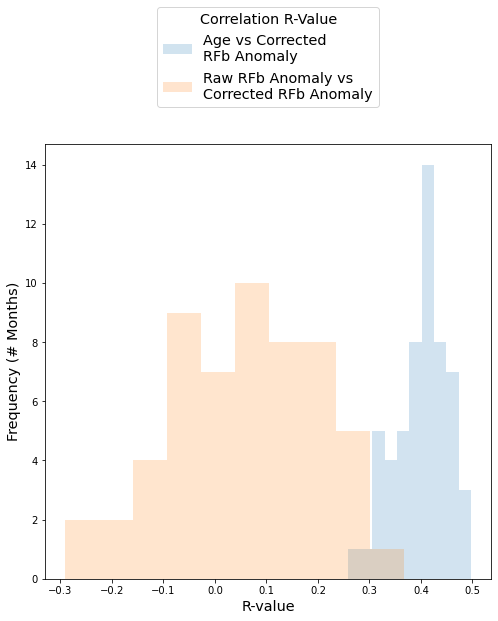

In [10]:
fig, (ax1) = plt.subplots(1,1,figsize=(8,8))

ax1.hist(stats_df['r_val_age'],alpha=0.2,label='Age vs Corrected\nRFb Anomaly')
ax1.hist(stats_df['r_val_rfb'],alpha=0.2,label='Raw RFb Anomaly vs\nCorrected RFb Anomaly')
# plt.hist(stats_df['r_val_CS'],alpha=0.2,label='R-Value Correlation Strength\nAge vs Correction Size')
ax1.legend(fontsize='x-large',bbox_to_anchor=(0.5,1.2),loc='center',title='Correlation R-Value',
           title_fontsize='x-large')
ax1.set_xlabel('R-value',fontsize='x-large')
ax1.set_ylabel('Frequency (# Months)',fontsize='x-large')
# plt.hist(stats_df['r_val_CS'],alpha=0.2)

LinregressResult(slope=-0.9318368545050084, intercept=0.12683507506813152, rvalue=-0.791833986031811, pvalue=0.0, stderr=0.00041124723014401095, intercept_stderr=8.853822467342668e-05)


Text(0.5, 0.9, 'r = -0.79')

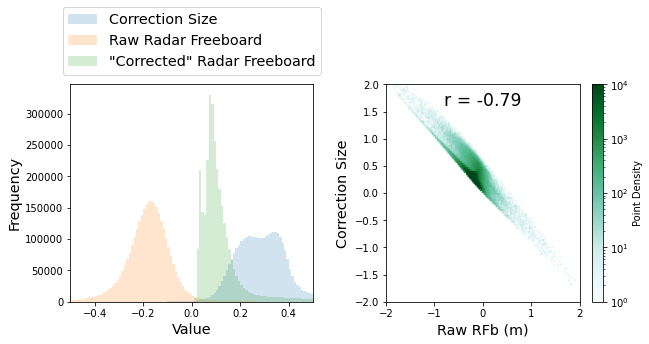

In [327]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.hist(df['correction_size'],alpha=0.2,
         label='Correction Size',
         bins=np.arange(-0.5,0.51,0.01))

ax1.hist(df['raw_raw'],
         alpha=0.2,label='Raw Radar Freeboard',
         bins=np.arange(-0.5,0.51,0.01))


ax1.hist(df['corr_raw'],
         alpha=0.2,label='"Corrected" Radar Freeboard',
         bins=np.arange(-0.5,0.51,0.01))

ax1.legend(fontsize='x-large',bbox_to_anchor=(0.5,1.2),loc='center')
ax1.set_xlabel('Value',fontsize='x-large')
ax1.set_ylabel('Frequency',fontsize='x-large')

ax1.set_xlim(-0.5,0.5)




hb = ax2.hexbin(df['raw_raw'],df['correction_size'],cmap='BuGn',bins='log',gridsize=300,vmin=1,vmax=10e3)
ax2.set_xlabel('Raw RFb (m)',fontsize='x-large')
ax2.set_ylabel('Correction Size',fontsize='x-large')
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)
cb = fig.colorbar(hb)
cb.set_label('Point Density')

fig.subplots_adjust(wspace=0.3)

lr = linregress(df['raw_raw'],df['correction_size'])
print(lr)
ax2.annotate(f'r = {np.round(lr[2],decimals=2)}',
            ha='center',xy=(0.5,0.9),xycoords='axes fraction',fontsize='xx-large')

# plt.hist(stats_df['r_val_CS'],alpha=0.2)

In [303]:
df.shape

(3054312, 8)

In [322]:
linregress(df['raw_raw'],df['corr_raw']),linregress(df['age'],df['corr_raw'])

(LinregressResult(slope=0.0681631455260568, intercept=0.12683495586450533, rvalue=0.09441601519699429, pvalue=0.0, stderr=0.000411247230207413, intercept_stderr=8.853822468707663e-05),
 LinregressResult(slope=0.0368404101615807, intercept=0.05860182728484922, rvalue=0.22269296115372386, pvalue=0.0, stderr=9.228187623618954e-05, intercept_stderr=0.00014720231899599615))

In [323]:
linregress(df['raw_raw'],df['age'])

LinregressResult(slope=-0.3783849358435722, intercept=1.4458402079680936, rvalue=-0.08670573982839054, pvalue=0.0, stderr=0.0024876585926665233, intercept_stderr=0.0005355729090531764)

In [247]:
df.columns

Index(['age', 'raw', 'corrected', 'correction_size', 'month', 'date'], dtype='object')

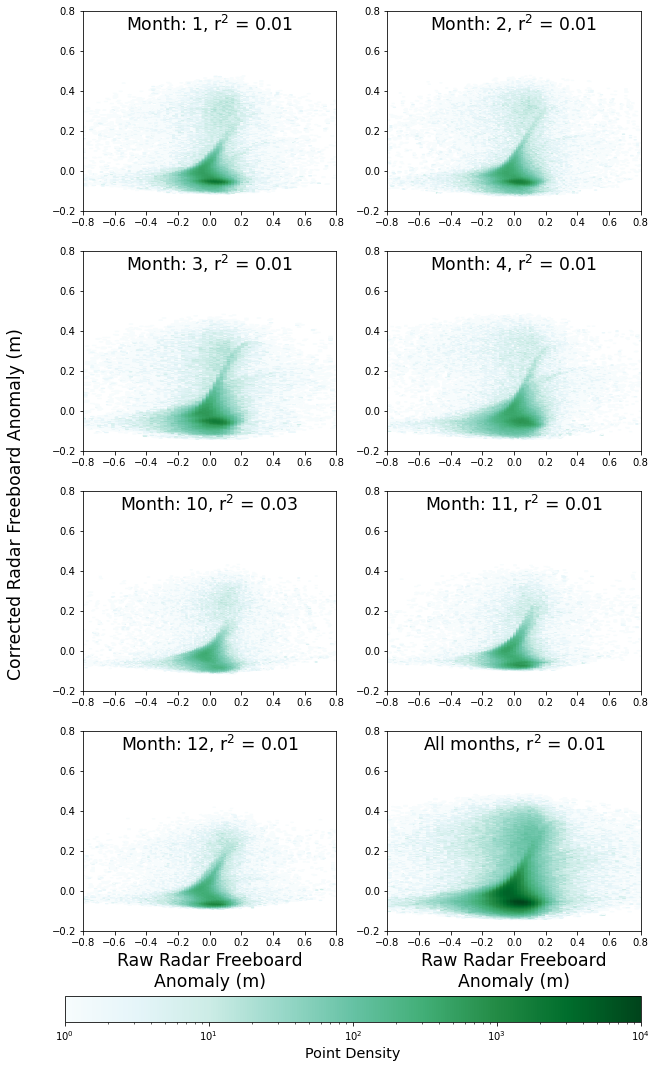

In [282]:
fig, axs = plt.subplots(4,2,figsize=(10,18))
    

for month, ax in zip(set(df['month']),axs.reshape(-1)):


    df_ = df[df['month']==month]

    hb = ax.hexbin(df_['raw'],df_['corrected'],cmap='BuGn',gridsize=300,bins='log',vmin=1,vmax=10e3)

    lim = 0.8

    ax.set_ylim(-0.2,lim)
    ax.set_xlim(-lim,lim)
    
#     ax.plot([-10,10],[-10,10],color='k')

#     ax.set_xlabel('Raw Radar Freeboard Anomaly (m)',fontsize='x-large')

#     ax.set_ylabel('Corrected Radar\nFreeboard Anomaly (m)',fontsize='x-large')

    lr = linregress(df_['raw'],df_['corrected'])

    ax.annotate(f'Month: {month}, r$^2$ = {np.round(lr[2]**2,decimals=2)}',
                ha='center',xy=(0.5,0.9),xycoords='axes fraction',fontsize='xx-large')
    

##
ax = axs.reshape(-1)[-1]
hb = ax.hexbin(df['raw'],df['corrected'],cmap='BuGn',gridsize=300,bins='log',vmin=1,vmax=10e3)
lim = 0.8
ax.set_ylim(-0.2,lim)
ax.set_xlim(-lim,lim)
lr = linregress(df['raw'],df['corrected'])
ax.annotate(f'All months, r$^2$ = {np.round(lr[2]**2,decimals=2)}',
            ha='center',xy=(0.5,0.9),xycoords='axes fraction',fontsize='xx-large')
    

fig.supylabel('Corrected Radar Freeboard Anomaly (m)',fontsize='xx-large')
    
for ax in axs.reshape(-1)[-2:]:
    ax.set_xlabel('Raw Radar Freeboard\nAnomaly (m)',fontsize='xx-large')
    
# for ax in axs.reshape(-1)[::1]:
#     ax.set_xlabel('Corrected Radar\nFreeboard (m)')
    
    
fig.subplots_adjust(bottom=0.17)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])
cb = fig.colorbar(hb, cax=cbar_ax,orientation='horizontal')
cb.set_label('Point Density',fontsize='x-large')


    
plt.show()

0


/tmp/ipykernel_16859/253776878.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corrected = d['radar_freeboard_corr_mean'][time]
/tmp/ipykernel_16859/253776878.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw =  d['radar_freeboard'][time]


1
2
3


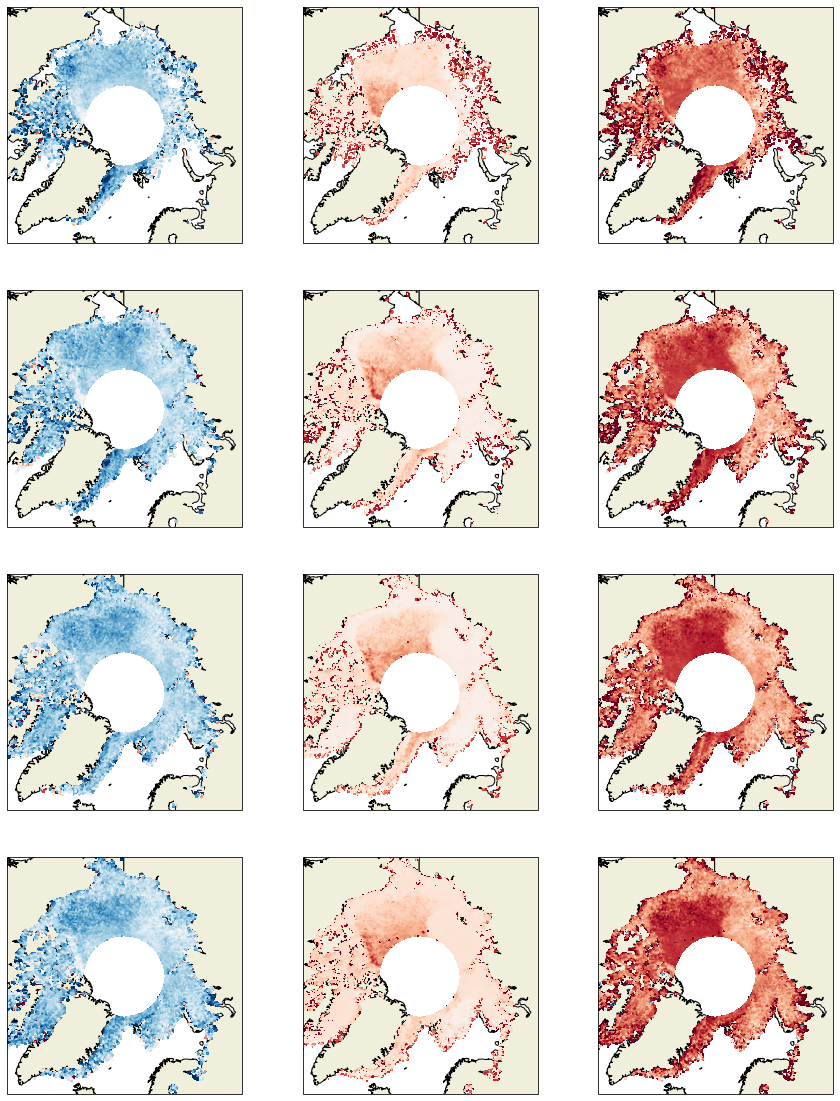

In [184]:
ranger = np.arange(4)

fig, axs = plt.subplots(len(ranger),3,figsize=(15,5*len(ranger)),subplot_kw={'projection':ccrs.NorthPolarStereo()})

for ax in axs.reshape(-1):

    ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
    ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())
    
    

for i, date in zip(ranger,dates):
    
    ax1,ax2,ax3 = axs[i]

    time = i   

    corrected = d['radar_freeboard_corr_mean'][time]
    raw =  d['radar_freeboard'][time]

    for data in [corrected,raw]:

        data[data<-100] = np.nan

    vmin = -0.5
    vmax = 0.5

    ax1.pcolormesh(d['lon'],d['lat'],raw[:-1,:-1],vmin=vmin,vmax=vmax,cmap='RdBu_r',transform=ccrs.PlateCarree())

    ax2.pcolormesh(d['lon'],d['lat'],corrected[:-1,:-1],vmin=vmin,vmax=vmax,cmap='RdBu_r',transform=ccrs.PlateCarree())

    diff = corrected - raw

    ax3.pcolormesh(d['lon'],d['lat'],diff[:-1,:-1],vmin=vmin,vmax=vmax,cmap='RdBu_r',transform=ccrs.PlateCarree())


# Here's a histogram of the TFMRA80 radar freeboards from the AWI product. Kind of like a Poisson distribution. It looks very different to the normal distribution of the TFMRA

In [309]:
import os
import pickle

/tmp/ipykernel_16859/2299159885.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(Dataset(dir + '/' + i)['radar_freeboard']).ravel()


(array([3.0000e+00, 7.0000e+00, 7.0000e+00, 1.2000e+01, 1.3000e+01,
        2.4000e+01, 4.5000e+01, 5.4000e+01, 1.0400e+02, 1.3700e+02,
        2.0100e+02, 3.5300e+02, 5.4400e+02, 8.7300e+02, 1.4900e+03,
        2.4320e+03, 3.9670e+03, 7.0120e+03, 1.2374e+04, 2.1056e+04,
        3.4835e+04, 5.0622e+04, 6.5706e+04, 7.6043e+04, 8.1721e+04,
        8.1167e+04, 7.7101e+04, 7.1646e+04, 6.5511e+04, 5.9286e+04,
        5.2698e+04, 4.6895e+04, 4.1531e+04, 3.6710e+04, 3.2533e+04,
        2.8817e+04, 2.5918e+04, 2.3098e+04, 2.0587e+04, 1.8275e+04,
        1.6445e+04, 1.4753e+04, 1.2928e+04, 1.1402e+04, 1.0326e+04,
        8.9230e+03, 7.8420e+03, 6.7900e+03, 5.9460e+03, 5.2140e+03,
        4.6190e+03, 4.0450e+03, 3.4710e+03, 3.1180e+03, 2.7460e+03,
        2.3880e+03, 2.1470e+03, 1.9700e+03, 1.7380e+03, 1.5300e+03,
        1.4280e+03, 1.3070e+03, 1.0840e+03, 1.0620e+03, 9.6500e+02,
        9.0100e+02, 7.7000e+02, 7.1300e+02, 6.3800e+02, 5.5800e+02,
        4.9700e+02, 4.7000e+02, 4.0100e+02, 3.89

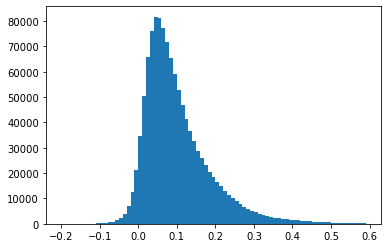

In [321]:
dir = '/home/robbie/Dropbox/SM_Thickness_Thesis/data/AWI_CS2'


rfs = []

for i in os.listdir(dir):
    
    if '.nc' in i:
    
        x = np.array(Dataset(dir + '/' + i)['radar_freeboard']).ravel()

        x[x>50] = np.nan
        x[x<-50] = np.nan

        rfs += list(x[~np.isnan(x)])
    
#     break
    
plt.hist(rfs,bins=np.arange(-0.2,0.6,0.01))